<a href="https://colab.research.google.com/github/uol-mediaprocessing-2023-2024-classroom/project-cartoonifiers/blob/main/CartoonifyDocumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartoonify Project

Medienverarbeitung, UOL

Antoine Daligault, Bastien Vincent and Vincent Voisin

The basic idea for this project was to create an interactive image modification tool for caricaturing.

We were trying to get close to the example of the lecture that introduced us to this project. This example is pictured below :


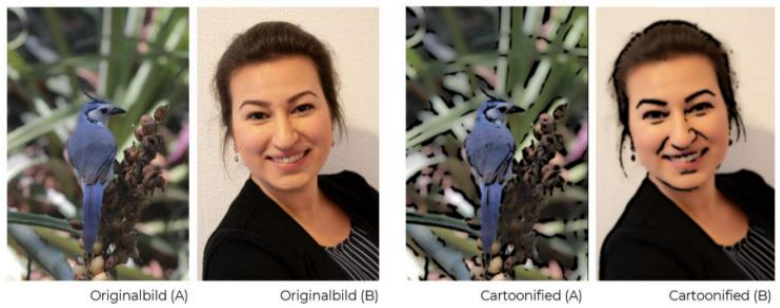

Our aim is to build a Web App to transform a real life picture into a cartoon picture while allowing the user to change some parameters, or relying on AI to achieve this.


For this, our first approach was to use Python and OpenCV to apply filters to an image and transform it. Then we also tried implementing some AI to achieve a better result. Those two approaches will be explained in details in this documentation, along some explications for the web interface made with Vue.


# Using Filters

## Explanations

As said before, our first approach was to use filters seen in class to get close to the lecture’s example. For this, the very first iteration of this approach used a grayscale version of the original image to find the edges of the elements in the picture. Then we used a bilateral filter on the original image and finally we obtained the cartoon image by combining the two.


In [ ]:
# !EXAMPLE CODE! - Working code in following part

# original image
imgbase = cv2.imread("image.jpg")
imgbase = cv2.cvtColor(imgbase, cv2.COLOR_BGR2RGB)
# grayscale conversion
grayimg = cv2.cvtColor(imgbase,cv2.COLOR_RGB2GRAY)
grayimg = cv2.medianBlur(grayimg, 5)
# edge filter
edges = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
# bilateral filter
color = cv2.bilateralFilter(imgbase, 7, 250, 250)
# combining bilateral and edges
cartoon = cv2.bitwise_and(color, color, mask=edges)

This first result was adequate, but not enough. So we added two more filters to the code, a contrast increase and a color quantization.

**Increasing the contrast**

Cartoons are often bright and contrasted images. Increasing the contrast will also help with the edges and other filters.

But we want to avoid saturating the image too much, so we use a specific method called CLAHE, coupled with another color space than BGR or RGB.

In [ ]:
#converting to LAB color space
lab= cv2.cvtColor(imgbase, cv2.COLOR_RGB2LAB)
l_channel, a, b = cv2.split(lab)
# Applying CLAHE to L-channel to increase the contrast
grid = 1
clahe = cv2.createCLAHE(clipLimit=grid, tileGridSize=(9,9)) #the limit and grid size can be user interactable
cl = clahe.apply(l_channel)
# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))
# Converting image from LAB back to BGR color
img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

**Reducing the Color Palette**

A key difference between photographs and cartoons is the number of distinct colors. A cartoon sketch will have less colors as compared to an actual picture. So we use a method called "colour quantization". This will reduce the number of colours in the image.

K Means clustering algorithm is used to perform the process. The “k” value is adjusted  by the user depending on the number of colors needed.

In [ ]:
#k value determines the total number of colors in the image, the user will be able to change it
k = 32
# Transform the image
data = np.float32(img).reshape((-1, 3))
# Determine criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)
# Implementing K-Means
ret, label, center = cv2.kmeans(data, k, None, criteria, 8, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
result = center[label.flatten()]
result = result.reshape(img.shape)

You can find below how the final working code looks like. The comments will also help you understand what is happening in details.

## Working Code

##### Imports

In [ ]:
# this cell is specific to google colab and is used to mount the drive files
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# basic imports needed throughout the project
import cv2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

##### Original image

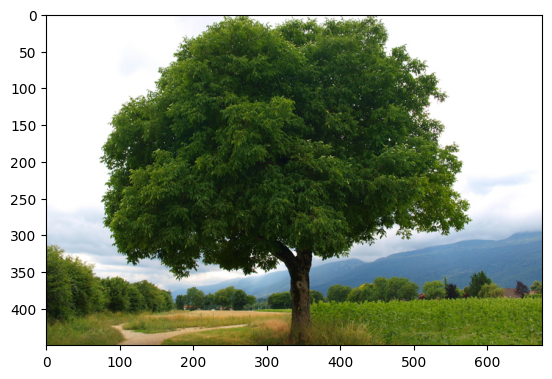

In [ ]:
# load the original image stored in the drive,  and show it
imgbase = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tree.jpg')
imgbase = cv2.cvtColor(imgbase, cv2.COLOR_BGR2RGB)
plt.imshow(imgbase)

##### Contrast Increase

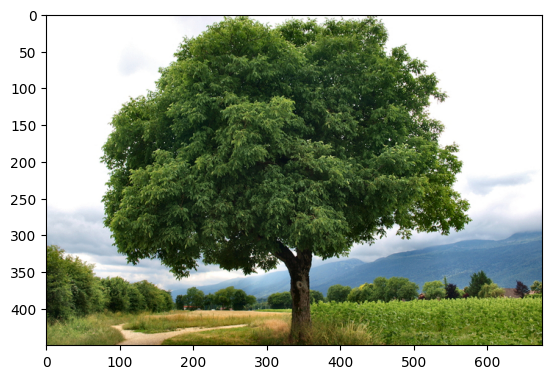

In [ ]:
#converting to LAB color space
lab= cv2.cvtColor(imgbase, cv2.COLOR_RGB2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel to increase the contrast
grid = 1
clahe = cv2.createCLAHE(clipLimit=grid, tileGridSize=(9,9)) #the limit and grid size can be user interactable
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB back to BGR color
img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
plt.imshow(img)

##### Grayscale conversion

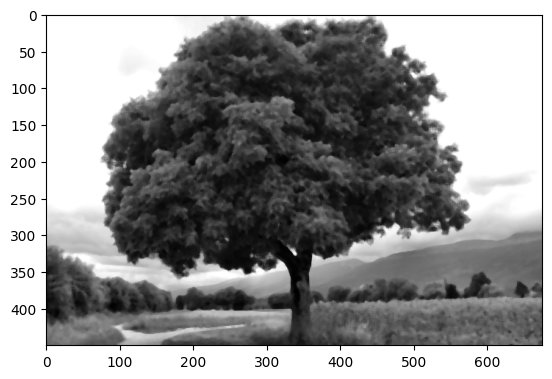

In [ ]:
# convert the image to grayscale
grayimg = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
grayimg = cv2.medianBlur(grayimg, 5)
plt.imshow(grayimg, cmap='gray')

##### Edge filter

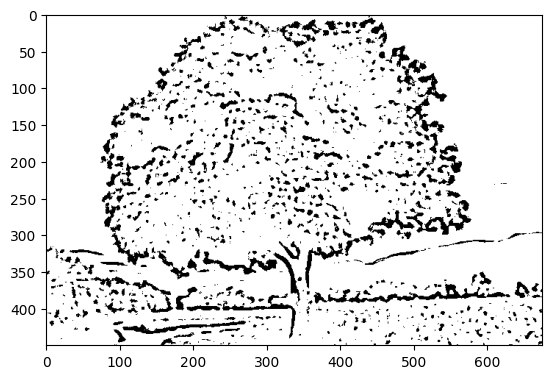

In [ ]:
# applying the edge filter
kernel = 13 #size of kernel determined by the user. the bigger it is, the less noise we get but the image needs to be large enough to keep all basic details
edges = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, kernel, kernel)
plt.imshow(edges, cmap='gray')

##### Color quantization

In [ ]:
#color quantization
#k value determines the total number of colors in the image, the user will be able to change it
k = 32

# Transform the image
data = np.float32(img).reshape((-1, 3))

# Determine criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)

# Implementing K-Means
ret, label, center = cv2.kmeans(data, k, None, criteria, 8, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
result = center[label.flatten()]
result = result.reshape(img.shape)

##### Bilateral filter and final step

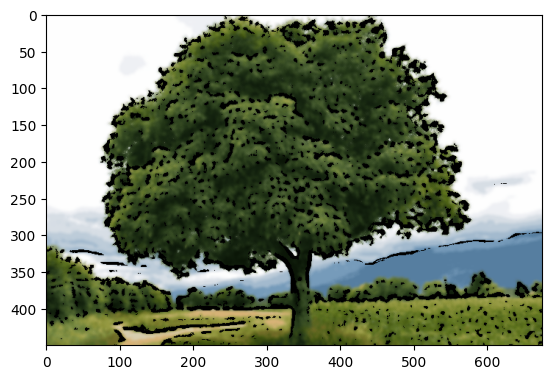

In [ ]:
# the final result printed in colors
color = cv2.bilateralFilter(result, 7, 250, 250)
cartoon = cv2.bitwise_and(color, color, mask=edges)
plt.imshow(cartoon)

# Using AI

The AI implemented in our group project is based on the research paper titled "Learning to Cartoonize Using White-box Cartoon Representations" authored by Xinrui Wang and Jinze Yu, published in June 2020.

This AI system functions through a systematic process of segmenting input photographs into three distinct representations crucial for transforming images into cartoons. By breaking down images into surface, structure, and texture representations, the AI gains insight into the fundamental components of visual content, enabling it to replicate cartoon aesthetics. This segmentation process serves as the cornerstone of its cartoonization capabilities.

The surface representation imitates the painting style commonly found in cartoons, where artists use coarse brushes to create smooth surfaces resembling cartoon images.

The structure representation aims to replicate flattened global content, sparse color blocks, and clear boundaries characteristic of cel-style cartoon workflows. Initially, we employ the Felzenszwalb algorithm to segment images into distinct regions. As conventional superpixel algorithms may decrease global contrast and darken images, we introduce an adaptive coloring algorithm to address these issues.

The texture representation focuses on capturing high-frequency features of cartoon images while minimizing the influence of color and luminance, which are distinguishing factors between cartoons and real-world photos.

Moreover, the AI's development and training were refined using a curated dataset comprising works from Studio Ghibli and Makoto Shinkai, serving as a valuable resource for guiding the AI's learning process.

To run the AI properly, an NVIDIA GPU and the CUDA CuDNN are needed. As well as tensorflow gpu version 1.12.0 and 1.13.0rc0 and scikit-image version 0.14.5.

# Web Interface

The Graphical user interface (GUI) is created by using html, css and javascript. Since it is a webapp we use the standard languages for building web pages.

**Html** is the language that will give the content and the general structure of our document. This is done by setting up division in your text and giving this division a tag so it can be called in the other languages.

**CSS** is the styling sheet, it enables the tuning of the layout, color and fonts as well as defining the size of the different divisions set up in the html.

**Javascript** is a programming language that is used to trigger all executables, pop-ups, show or hide interactions. Basically javascript makes a website dynamic and allows interaction.


## Frontend

For the project, because the GUI wasn’t the main goal of the project, we had a template to make a web page using vuetify.js. Vuetify is a framework that helps create interfaces.This framework comes with its own libraries, making it easier to add objects on the interface.

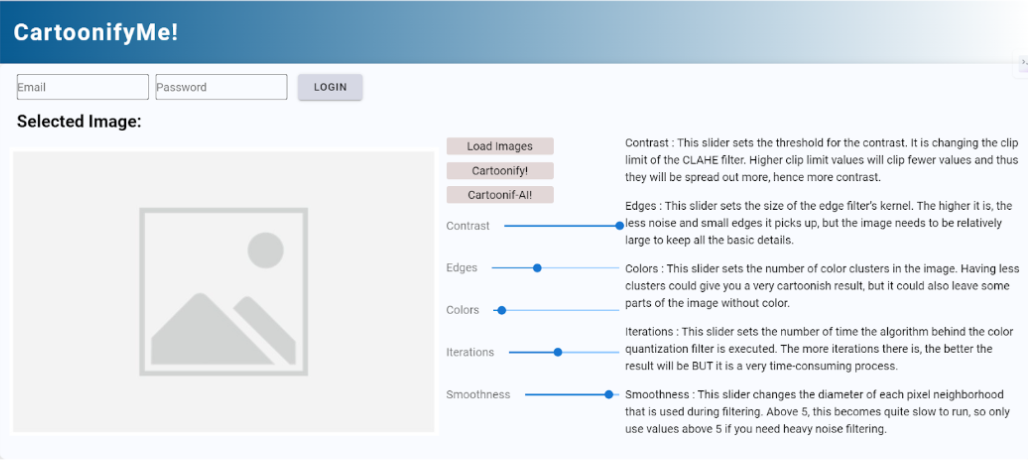

In our project, we still saw a big value in creating a GUI that would benefit the user most of all. The first way to empower the user is to give him controls that are consistent and intuitive.

We chose to put a touch of color on the page title part, otherwise the initial page would just have been in grayscale colors. Also adding more color would be distracting and give too many visual cues that might even change the visualization of the image that is displayed on the page which is why we stayed as simple as possible.

Right Under the title banner there is the login form for the access to the CEWE image database. After login in the user will see his name instead of the form. Also by clicking the “load image” button he will load the images at the bottom of the interface.
Selecting an image at the bottom will set it as the selected image and it will take the place of the placeholder on the left of the interface.


To the right of the image there is the “load image” button to refresh the image database at the bottom if the user uploads images on CEWE. In between there is the “Cartoonify!” button, this button will launch the enhancement of the image using the filter. This method will use the parameters set up on the sliders under the buttons, it will trigger a loading screen displayed over the division between the title banner and the images at the bottom. This way the user gets visual feedback of the actions he is doing and knows that computation is being done. The last button “Cartoonif-AI” is enhancing the image using the AI build-in the webapp. This computation didn’t require loading feedback because it is very fast.

Under the buttons, the user will find the parameters he can set for the filter. There are 5 different parameters: contrast, edges, colors, iterations, and smoothness. For every user that does image editing will know what these parameters mean. For users that aren’t editing images on a hobby or professional basis, we put the descriptions of the parameters. We would have liked to make these descriptions a hover pop-up when putting your mouse on a slider, but we did not manage to find a vuetify library on the version of the framework that is in use to enable this. Making the descriptions pop-ups would have helped us to declutter the interface.
The use of sliders has many reasons, by using sliders we have an ergonomic, simple and intuitive way for the user to change the parameters, the user can set a value he wants or just set it higher or lower if the first result is not as wanted. For users that don’t know what the values mean or how they compare to normal values, using sliders they can see that a value is high or low on the slider, some go from 0 to 128 whereas others go from 1 to 10. The bonus is that the code doesn’t need to consider values that can’t be taken as input (ex.: negative values).


## Backend

While having a user friendly UI was one of our main goals, we still have to link this UI to the code behind the project. For this, we use python and Vue to help the communication between the front and the back.

### Filters

The sliders present in the UI are representative of real variable used in the filters. We are able to get those values through emitted URLs via Vue. The slider values are sent in the form of an array for efficiency purposes.

In [ ]:
// Emit a getCartoon event with the ID of the selected image.
        getCartoon(selectedId) {
            var sliderValues = "["+this.sliderGrid+","+this.sliderEdge+","+this.sliderK+","+this.sliderIter+","+this.sliderBila+"]";
            this.$emit("getCartoon", selectedId, this.cldId, sliderValues);
        },

They are then retrieved by a python function and inserted in the right filters.

In [ ]:
@app.get("/get-cartoon/{cldId}/{imgId}/{sliderValues}")
async def get_cartoon(cldId: str, imgId: str,sliderValues: str, background_tasks: BackgroundTasks):
    img_path = f"app/bib/{imgId}.jpg"
    image_url = f"https://cmp.photoprintit.com/api/photos/{imgId}.org?size=original&errorImage=false&cldId={cldId}&clientVersion=0.0.1-medienVerDemo"
    img_path_final = f"app/bib/temp.jpg"

    #values = np.array(literal_eval(sliderValues)) --> moved into the apply_cartoon function

    download_image(image_url, img_path)
    apply_cartoon(img_path, sliderValues, img_path_final)

    # Schedule the image file to be deleted after the response is sent
    background_tasks.add_task(remove_file, img_path)

    # Send the blurred image file as a response
    return FileResponse(img_path_final)


Here is the function inside the main.py file that is responsible for the filters

In [ ]:
def apply_cartoon(img_path: str, sliderValues, img_path_final):
    #load values and convert string to numpy array
    values = np.array(literal_eval(sliderValues))
    #load image
    imgbase = cv2.imread(img_path)
    imgbase = cv2.cvtColor(imgbase, cv2.COLOR_BGR2RGB)
    #contrast
    lab= cv2.cvtColor(imgbase, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=values[0], tileGridSize=(9,9))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    #grayscale
    grayimg = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    grayimg = cv2.medianBlur(grayimg, 5)
    #edge filter
    edges = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, values[1], values[1])
    #color quantization
    data = np.float32(img).reshape((-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)
    ret, label, center = cv2.kmeans(data, values[2], None, criteria, values[3], cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    result = center[label.flatten()]
    result = result.reshape(img.shape)
    #final image
    color = cv2.bilateralFilter(result, values[4], 250, 250) #can change the kernel size for this filter
    cartoon = cv2.bitwise_and(color, color, mask=edges)
    final = Image.fromarray(cartoon)
    final.save(img_path_final)

This is basically the same code than the previous one, but adapted to fit a python file. All the values[n] are the slider values and their corresponding emplacement in the array.

### AI

Implementing the AI was quite similar to implementing the filters. Although the AI does not uses sliders we still emit the id of the picture selected.

In [ ]:
cartoonAI(selectedId){
            this.$emit("cartoonAI", selectedId, this.cldId);
        },

One thing to notice is that we have to assign two folder paths, one for the input and one for the output, and specify these paths as function arguments. Contrary to the filters, the image id is never sent to the apply_ai function, it is saved in a specific folder because this is how the ai originally works.

In [ ]:
@app.get("/cartoon-ai/{cldId}/{imgId}")
async def cartoonAI(cldId: str, imgId: str, background_tasks: BackgroundTasks):
    input_folder_path = "app/test_images"
    output_folder_path = "app/bib"
    img_path = f"app/test_images/{imgId}.jpg"
    image_url = f"https://cmp.photoprintit.com/api/photos/{imgId}.org?size=original&errorImage=false&cldId={cldId}&clientVersion=0.0.1-medienVerDemo"
    img_path_final = f"app/bib/{imgId}.jpg"

    download_image(image_url, img_path)
    apply_ai(input_folder_path,output_folder_path)

    # Schedule the image file to be deleted after the response is sent
    background_tasks.add_task(remove_file, img_path)
    #test

    # Send the blurred image file as a response
    return FileResponse(img_path_final)

For the apply_ai function we simply call the function from the original ai python file. This way we are sure that nothing could possibly break the ai as we didn't modifiy its code.

In [ ]:
def apply_ai(img_path: str, img_path_final):
    cartoonize.cartoonize(img_path, img_path_final, 'app/saved_models')

The final image is then saved in the mentioned folder, and we return this folder as a file reponse for the whole function.